<a href="https://colab.research.google.com/github/Sarayuma/attrition/blob/main/attrition_analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE  # Handle class imbalance
import shap
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
# Load the dataset
df = pd.read_csv('/content/hrdata.csv')

# Preprocessing
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df = df.drop(['EmployeeNumber', 'Over18', 'StandardHours'], axis=1)
df = pd.get_dummies(df, drop_first=True)

In [ ]:
# Split data
X = df.drop('Attrition', axis=1)
y = df['Attrition']
print(y)

0       1
1       0
2       1
3       0
4       0
       ..
1465    0
1466    0
1467    0
1468    0
1469    0
Name: Attrition, Length: 1470, dtype: int64


In [ ]:
print(df['Attrition'].value_counts())

Attrition
0    1233
1     237
Name: count, dtype: int64


In [ ]:
import joblib
joblib.dump(X.columns, 'feature_names.pkl')

['feature_names.pkl']

In [ ]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [ ]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save model and scaler
joblib.dump(xgb_best, 'attrition_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

Model 1: Logistic Regression (with Hyperparameter Tuning)

In [ ]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_params = {'C': [0.001, 0.01, 0.1, 1, 10], 'solver': ['liblinear', 'saga']}
lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring='roc_auc')
lr_grid.fit(X_train_scaled, y_train)
lr_best = lr_grid.best_estimator_

Model 2: Random Forest (Optimized)

In [ ]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10]}
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='roc_auc')
rf_grid.fit(X_train_scaled, y_train)
rf_best = rf_grid.best_estimator_

Model 3: XGBoost (Best for Imbalanced Data)

In [ ]:
xgb = XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
                    eval_metric='logloss', use_label_encoder=False)
xgb_params = {'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='roc_auc')
xgb_grid.fit(X_train_scaled, y_train)
xgb_best = xgb_grid.best_estimator_

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:24:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:24:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:24:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:24:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:24:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Model 4: Neural Network (Simple MLP)

In [ ]:
model_nn = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_nn.fit(X_train_scaled, y_train, epochs=50, batch_size=32,
                      validation_split=0.2, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
models = {
    'Logistic Regression': lr_best,
    'Random Forest': rf_best,
    'XGBoost': xgb_best
}

In [ ]:
# Evaluate traditional models
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
    print(classification_report(y_test, y_pred))


Logistic Regression Performance:
Accuracy: 0.897
ROC-AUC: 0.953
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       250
           1       0.91      0.87      0.89       244

    accuracy                           0.90       494
   macro avg       0.90      0.90      0.90       494
weighted avg       0.90      0.90      0.90       494


Random Forest Performance:
Accuracy: 0.927
ROC-AUC: 0.970
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       250
           1       0.96      0.89      0.92       244

    accuracy                           0.93       494
   macro avg       0.93      0.93      0.93       494
weighted avg       0.93      0.93      0.93       494


XGBoost Performance:
Accuracy: 0.927
ROC-AUC: 0.966
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       250
           1       0.96      0.89      0.92       244

    a

 Evaluate Neural Network

In [ ]:
nn_proba = model_nn.predict(X_test_scaled).flatten()
nn_pred = (nn_proba > 0.5).astype(int)
print("\nNeural Network Performance:")
print(f"Accuracy: {accuracy_score(y_test, nn_pred):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, nn_proba):.3f}")
print(classification_report(y_test, nn_pred))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Neural Network Performance:
Accuracy: 0.919
ROC-AUC: 0.963
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       250
           1       0.94      0.89      0.92       244

    accuracy                           0.92       494
   macro avg       0.92      0.92      0.92       494
weighted avg       0.92      0.92      0.92       494



Feature Importance (XGBoost)

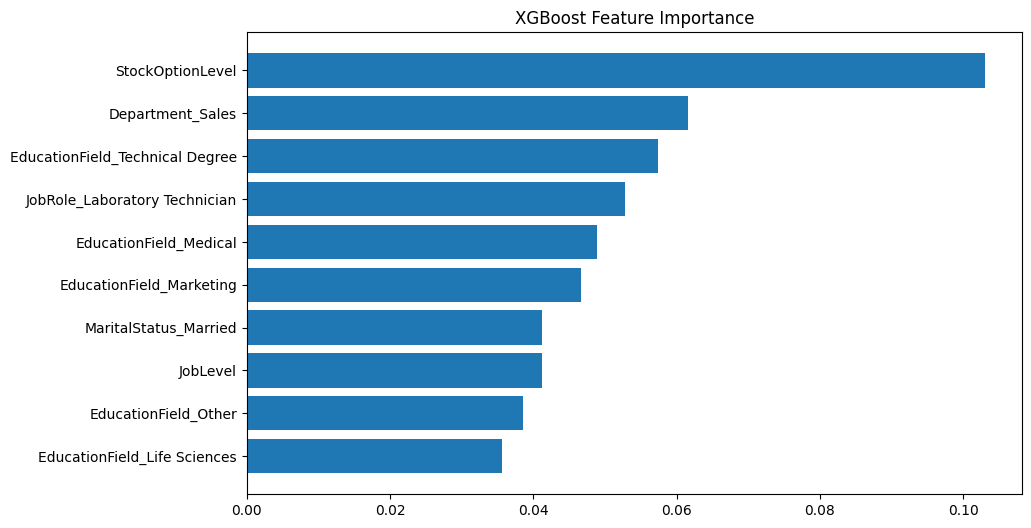

In [ ]:
plt.figure(figsize=(10, 6))
sorted_idx = xgb_best.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx][-10:], xgb_best.feature_importances_[sorted_idx][-10:])
plt.title("XGBoost Feature Importance")
plt.show()

 ROC Curve Comparison

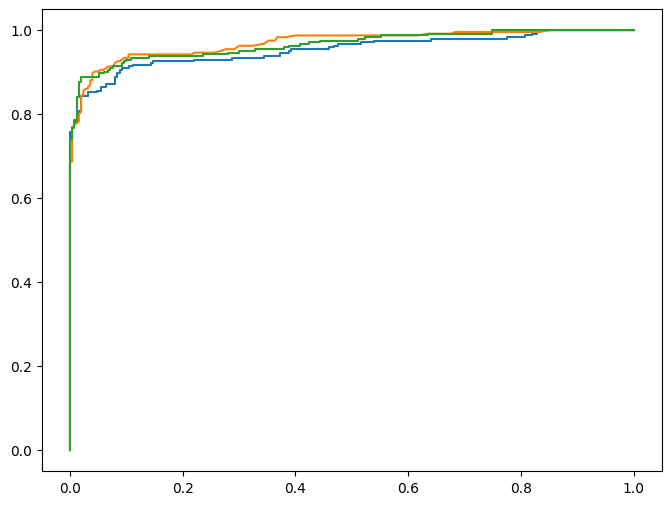

In [ ]:
plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')

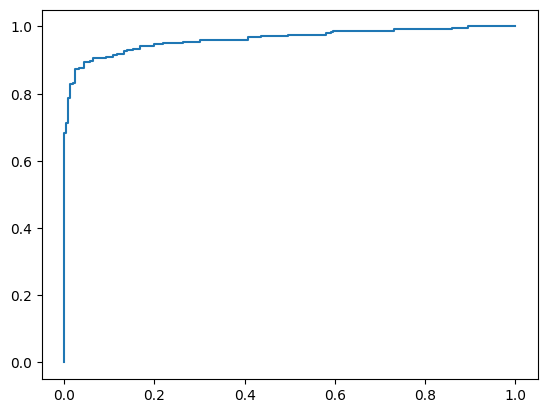

In [ ]:
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_proba)
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_score(y_test, nn_proba):.2f})')

<ipython-input-23-70236b98e649>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


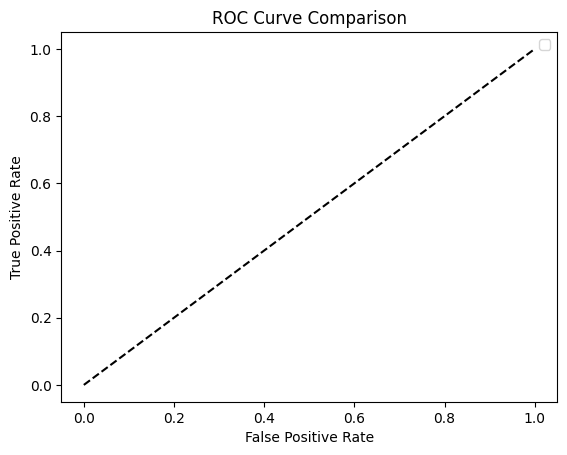

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


In [ ]:
import joblib

# Save the best model (e.g., XGBoost)
joblib.dump(xgb_best, 'attrition_model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [ ]:
import pandas as pd
import joblib

# Load the trained model, scaler, and feature names
model = joblib.load('attrition_model.pkl')
scaler = joblib.load('scaler.pkl')
feature_names = joblib.load('feature_names.pkl')  # Load saved feature names

def predict_attrition():
    # Input employee details
    print("Enter employee details:")
    age = int(input("Age: "))
    monthly_income = float(input("Monthly Income: "))
    overtime = input("Overtime (Yes/No): ").strip().capitalize()
    job_role = input("Job Role (e.g., 'Sales Executive', 'Research Scientist'): ").strip().capitalize()
    years_at_company = int(input("Years at Company: "))
    job_satisfaction = int(input("Job Satisfaction (1-4): "))

    # Create a DataFrame with all expected features initialized to 0
    data = {col: 0 for col in feature_names}

    # Update relevant features with input values
    data['Age'] = age
    data['MonthlyIncome'] = monthly_income
    data['OverTime_Yes'] = 1 if overtime == 'Yes' else 0
    data[f'JobRole_{job_role}'] = 1  # Set the specific job role column
    data['YearsAtCompany'] = years_at_company
    data['JobSatisfaction'] = job_satisfaction

    # Convert to DataFrame
    df = pd.DataFrame([data])

    # Ensure column order matches training data
    df = df[feature_names]

    # Scale features
    scaled_data = scaler.transform(df)

    # Predict
    prediction = model.predict(scaled_data)
    probability = model.predict_proba(scaled_data)[0][1]

    # Display result
    if prediction[0] == 1:
        print(f"\nPrediction: Employee is likely to leave (Probability: {probability:.2%})")
    else:
        print(f"\nPrediction: Employee will stay (Probability: {1 - probability:.2%})")

if __name__ == "__main__":
    predict_attrition()

Enter employee details:
Age: 50
Monthly Income: 50000
Overtime (Yes/No): Yes
Job Role (e.g., 'Sales Executive', 'Research Scientist'): Sales Executive
Years at Company: 9
Job Satisfaction (1-4): 4

Prediction: Employee is likely to leave (Probability: 80.13%)
